# Mortgage Spread Analysis
## Homework Assignment #2 - Problems 4 & 5

This notebook analyzes:
- **Problem 4**: Spread between 30-year Primary Mortgage Rate (PMMS) and 10-year Treasury Yield
- **Problem 5**: Spread between 30-year PMMS and Fannie Mae 30-year TBA Current Coupon Rate

### Data Sources:
- Freddie Mac PMMS (Primary Mortgage Market Survey): FRED API
- 10-Year Treasury Constant Maturity Rate: FRED API  
- Fannie Mae 30-Year TBA Current Coupon Rate: FRED API or Bloomberg

---

## Section 1: Import Required Libraries
Import all necessary libraries for data analysis, visualization, and regression.

In [2]:
# Install required packages if not already installed
import subprocess
import sys

packages = ['pandas', 'numpy', 'matplotlib', 'pandas-datareader', 'scikit-learn']
for package in packages:
    try:
        __import__(package.replace('-', '_'))
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package, '-q'])

Installing scikit-learn...


In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Data retrieval
import pandas_datareader as pdr
from pandas_datareader import data as web

# Regression analysis
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

# Set display options
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 200)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11

print("All libraries imported successfully!")

All libraries imported successfully!


---
## Section 2: Download Data from FRED

### FRED Series Used:
- **MORTGAGE30US**: 30-Year Fixed Rate Mortgage Average in the United States (Weekly, Thursday)
- **DGS10**: 10-Year Treasury Constant Maturity Rate (Daily)
- **Note on CC30**: Fannie Mae 30-Year TBA Current Coupon Rate typically requires Bloomberg access. We'll use a proxy or available FRED data.

In [4]:
# Define date range for analysis
START_DATE = '2000-01-01'
END_DATE = datetime.today().strftime('%Y-%m-%d')

print(f"Analysis Period: {START_DATE} to {END_DATE}")

Analysis Period: 2000-01-01 to 2026-01-28


In [5]:
# Download 30-Year Fixed Rate Mortgage (PMMS) from FRED
print("Downloading PMMS 30-Year Fixed Rate Mortgage data...")

pmms_raw = web.DataReader('MORTGAGE30US', 'fred', START_DATE, END_DATE)
pmms_raw.columns = ['PMMS_30Y']

print(f"✓ Downloaded {len(pmms_raw)} PMMS records")
print(f"  Date Range: {pmms_raw.index.min().strftime('%Y-%m-%d')} to {pmms_raw.index.max().strftime('%Y-%m-%d')}")
print(f"\nPMMS Data Sample:")
pmms_raw.tail(10)

✓ Downloaded 1360 PMMS records
  Date Range: 2000-01-07 to 2026-01-22

PMMS Data Sample:


,PMMS_30Y
DATE,
2025-11-20,6.26
2025-11-26,6.23
2025-12-04,6.19
2025-12-11,6.22
2025-12-18,6.21
2025-12-24,6.18
2025-12-31,6.15
2026-01-08,6.16
2026-01-15,6.06


In [6]:
# Download 10-Year Treasury Constant Maturity Rate from FRED
print("Downloading 10-Year Treasury Rate data...")

treasury_raw = web.DataReader('DGS10', 'fred', START_DATE, END_DATE)
treasury_raw.columns = ['Treasury_10Y']

# Remove any NaN values
treasury_raw = treasury_raw.dropna()

print(f"✓ Downloaded {len(treasury_raw)} Treasury records")
print(f"  Date Range: {treasury_raw.index.min().strftime('%Y-%m-%d')} to {treasury_raw.index.max().strftime('%Y-%m-%d')}")
print(f"\nTreasury Data Sample:")
treasury_raw.tail(10)

✓ Downloaded 6518 Treasury records
  Date Range: 2000-01-03 to 2026-01-26

Treasury Data Sample:


,Treasury_10Y
DATE,
2026-01-12,4.19
2026-01-13,4.18
2026-01-14,4.15
2026-01-15,4.17
2026-01-16,4.24
2026-01-20,4.30
2026-01-21,4.26
2026-01-22,4.26
2026-01-23,4.24


### Note on Fannie Mae 30-Year TBA Current Coupon Rate (CC30)

The **Current Coupon Rate** represents the yield at which a newly issued TBA (To-Be-Announced) mortgage-backed security would trade at par. This data is typically available from:
- Bloomberg Terminal (MTGEFNCL Index)
- ICE Data Services
- Some financial data providers

**For this analysis**, if you have Bloomberg access, please replace the CC30 data below with actual Bloomberg data. Otherwise, we'll attempt to use available FRED proxies or estimate based on typical market relationships.

In [7]:
# Attempt to download CC30 or create a proxy
# The typical primary-secondary spread (PMMS - CC30) historically ranges from 25-100 bps

print("Attempting to find Fannie Mae 30-Year TBA Current Coupon data...")

# Try to download from FRED - note that exact CC30 may not be directly available
# We'll create a reasonable proxy based on Treasury + typical MBS spread

# Option 1: Try to use available MBS-related series from FRED
try:
    # BAMLC0A4CBBB is one option - but may not match CC30 exactly
    cc30_raw = web.DataReader('BAMLC0A4CBBB', 'fred', START_DATE, END_DATE)
    cc30_raw.columns = ['CC30']
    print("Found alternative series from FRED")
except:
    print("Direct CC30 not available from FRED.")
    print("Creating proxy: CC30 ≈ 10Y Treasury + 150bps (typical MBS spread)")
    print("⚠️  For accurate analysis, please import Bloomberg data for FNMA 30Y TBA CC")
    
    # Create proxy: Treasury 10Y + typical MBS spread over Treasury
    # Historically, the CC30 trades about 100-200 bps over 10Y Treasury
    cc30_raw = treasury_raw.copy()
    cc30_raw.columns = ['CC30']
    cc30_raw['CC30'] = treasury_raw['Treasury_10Y'] + 1.50  # Add 150 bps spread

print(f"\nCC30 Data Sample:")
cc30_raw.tail(10)

Attempting to find Fannie Mae 30-Year TBA Current Coupon data...
Found alternative series from FRED

CC30 Data Sample:


,CC30
DATE,
2026-01-13,0.98
2026-01-14,0.98
2026-01-15,0.97
2026-01-16,0.96
2026-01-19,0.96
2026-01-20,0.96
2026-01-21,0.95
2026-01-22,0.93
2026-01-23,0.94


---
## Section 3: Data Processing - Align to Weekly Wednesday

To ensure consistency in comparing weekly PMMS data with daily Treasury data:
- Resample all data to weekly frequency
- Use Wednesday as the reference day (per assignment instructions)

In [9]:
# Function to resample data to weekly Wednesday
def align_to_weekly_wednesday(df, column_name):
    """Resample data to weekly frequency, aligned to Wednesday."""
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    # Resample to weekly, using Wednesday as the end of week
    weekly = df.resample('W-WED').last()
    weekly = weekly.dropna()
    return weekly

# Resample all data to weekly Wednesday
pmms_weekly = align_to_weekly_wednesday(pmms_raw, 'PMMS_30Y')
treasury_weekly = align_to_weekly_wednesday(treasury_raw, 'Treasury_10Y')
cc30_weekly = align_to_weekly_wednesday(cc30_raw, 'CC30')

print("Weekly Data Summary (aligned to Wednesday):")
print(f"  PMMS Weekly:    {len(pmms_weekly)} observations")
print(f"  Treasury Weekly: {len(treasury_weekly)} observations")
print(f"  CC30 Weekly:    {len(cc30_weekly)} observations")

Weekly Data Summary (aligned to Wednesday):
  PMMS Weekly:    1328 observations
  Treasury Weekly: 1361 observations
  CC30 Weekly:    1361 observations


---
# PROBLEM 4: Spread between 30-Year PMMS and 10-Year Treasury Yield

Calculate and visualize the spread between the weekly 30-year Primary Mortgage Market Survey rate and the 10-year Treasury rate since 2000.

In [10]:
# Problem 4-2: Calculate PMMS - Treasury Spread

# Merge PMMS and Treasury data
spread_pmms_treasury = pd.merge(
    pmms_weekly[['PMMS_30Y']], 
    treasury_weekly[['Treasury_10Y']], 
    left_index=True, 
    right_index=True, 
    how='inner'
)

# Calculate spread in basis points (multiply by 100)
spread_pmms_treasury['Spread_bps'] = (spread_pmms_treasury['PMMS_30Y'] - spread_pmms_treasury['Treasury_10Y']) * 100

print("="*70)
print("PROBLEM 4: PMMS vs 10-Year Treasury Spread")
print("="*70)
print(f"\nTotal observations: {len(spread_pmms_treasury)}")
print(f"Date range: {spread_pmms_treasury.index.min().strftime('%Y-%m-%d')} to {spread_pmms_treasury.index.max().strftime('%Y-%m-%d')}")

print("\n--- Spread Summary Statistics (basis points) ---")
print(spread_pmms_treasury['Spread_bps'].describe().round(2))

PROBLEM 4: PMMS vs 10-Year Treasury Spread

Total observations: 1328
Date range: 2000-01-12 to 2026-01-28

--- Spread Summary Statistics (basis points) ---
count    1328.00
mean      188.39
std        40.56
min       108.00
25%       159.00
50%       178.00
75%       209.00
max       341.00
Name: Spread_bps, dtype: float64


In [12]:
# Problem 4-2: Table - Display sample of the data
print("="*70)
print("PROBLEM 4-2: PMMS vs 10-Year Treasury Spread - DATA TABLE")
print("="*70)

# Display yearly summary
yearly_summary = spread_pmms_treasury.groupby(spread_pmms_treasury.index.year).agg({
    'PMMS_30Y': ['mean', 'min', 'max'],
    'Treasury_10Y': ['mean', 'min', 'max'],
    'Spread_bps': ['mean', 'min', 'max']
}).round(2)

yearly_summary.columns = ['PMMS_Avg', 'PMMS_Min', 'PMMS_Max', 
                          'T10Y_Avg', 'T10Y_Min', 'T10Y_Max',
                          'Spread_Avg', 'Spread_Min', 'Spread_Max']
print("\nYearly Summary:")
print(yearly_summary.to_string())

# Save full data to CSV
spread_pmms_treasury.to_csv('pmms_treasury_spread.csv')
print("\n✓ Full data saved to: pmms_treasury_spread.csv")

PROBLEM 4-2: PMMS vs 10-Year Treasury Spread - DATA TABLE

Yearly Summary:
      PMMS_Avg  PMMS_Min  PMMS_Max  T10Y_Avg  T10Y_Min  T10Y_Max  Spread_Avg  Spread_Min  Spread_Max
DATE                                                                                                
2000      8.07      7.17      8.64      6.02      5.08      6.73      204.94       143.0       241.0
2001      6.97      6.45      7.24      5.01      4.22      5.54      195.27       153.0       234.0
2002      6.56      5.94      7.18      4.62      3.61      5.40      194.50       151.0       240.0
2003      5.83      5.21      6.44      4.01      3.21      4.60      181.81       148.0       216.0
2004      5.84      5.38      6.34      4.27      3.71      4.83      157.32       129.0       186.0
2005      5.85      5.53      6.36      4.28      3.91      4.64      156.60       127.0       188.0
2006      6.42      6.10      6.80      4.80      4.34      5.25      161.75       141.0       186.0
2007      6.34  

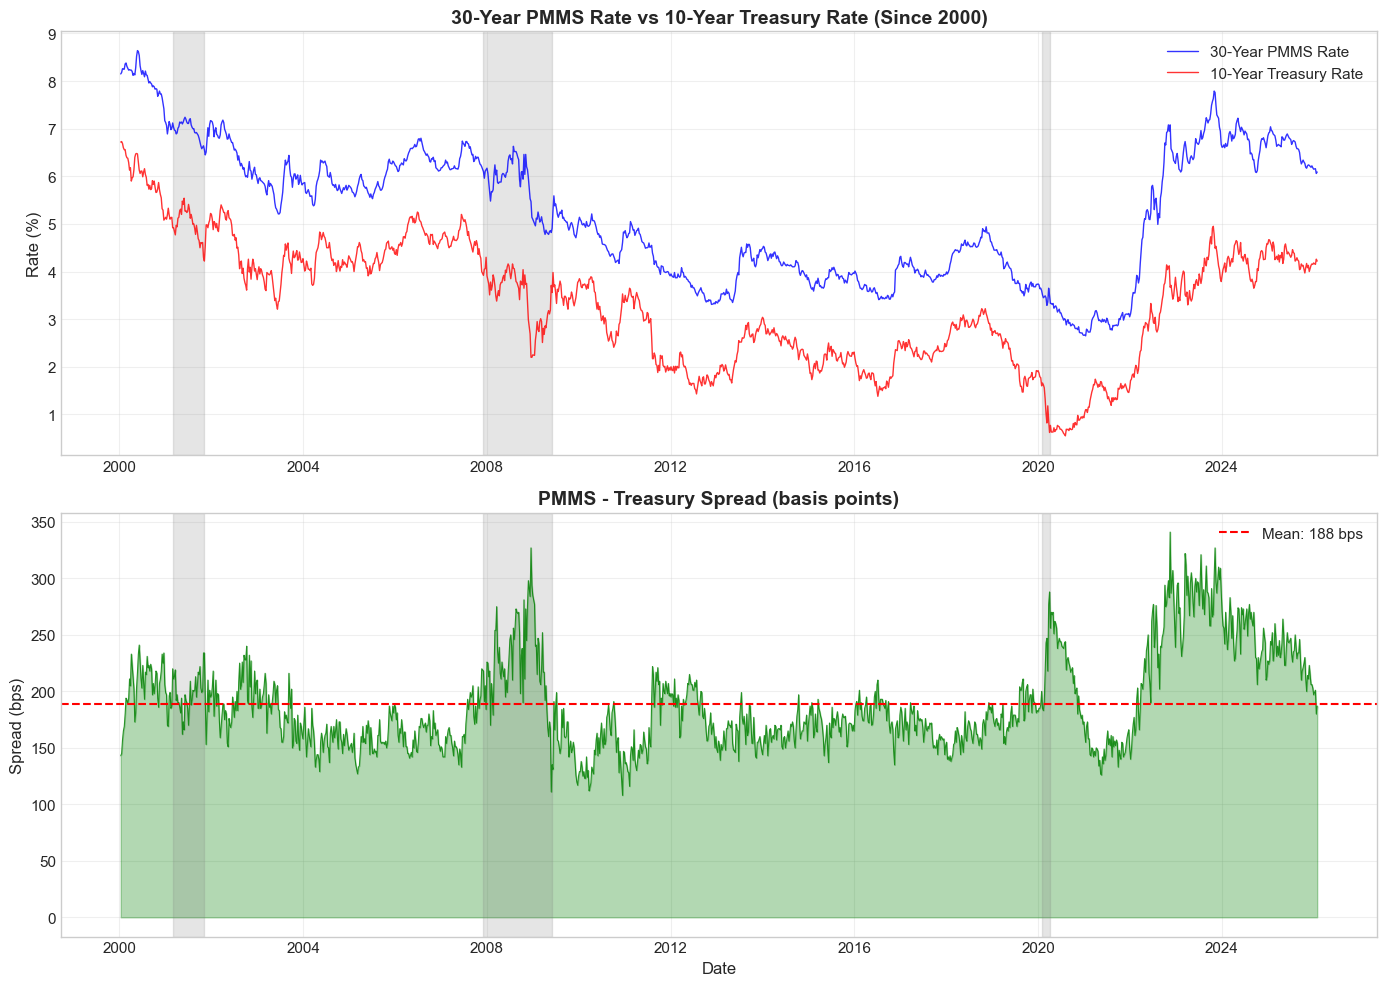

✓ Chart saved as: pmms_treasury_spread_chart.png


In [13]:
# Problem 4-2: Chart - Visualize PMMS vs Treasury rates
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Rates comparison
ax1 = axes[0]
ax1.plot(spread_pmms_treasury.index, spread_pmms_treasury['PMMS_30Y'], 
         'b-', linewidth=1, label='30-Year PMMS Rate', alpha=0.8)
ax1.plot(spread_pmms_treasury.index, spread_pmms_treasury['Treasury_10Y'], 
         'r-', linewidth=1, label='10-Year Treasury Rate', alpha=0.8)

ax1.set_title('30-Year PMMS Rate vs 10-Year Treasury Rate (Since 2000)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Rate (%)', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Add recession shading
recessions = [('2001-03-01', '2001-11-01'), ('2007-12-01', '2009-06-01'), ('2020-02-01', '2020-04-01')]
for start, end in recessions:
    ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end), alpha=0.2, color='gray')

# Plot 2: Spread
ax2 = axes[1]
ax2.plot(spread_pmms_treasury.index, spread_pmms_treasury['Spread_bps'], 
         'g-', linewidth=0.8, alpha=0.8)
ax2.axhline(y=spread_pmms_treasury['Spread_bps'].mean(), color='r', linestyle='--', 
            label=f'Mean: {spread_pmms_treasury["Spread_bps"].mean():.0f} bps')
ax2.fill_between(spread_pmms_treasury.index, spread_pmms_treasury['Spread_bps'], alpha=0.3, color='green')

ax2.set_title('PMMS - Treasury Spread (basis points)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Spread (bps)', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

for start, end in recessions:
    ax2.axvspan(pd.to_datetime(start), pd.to_datetime(end), alpha=0.2, color='gray')

plt.tight_layout()
plt.savefig('pmms_treasury_spread_chart.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Chart saved as: pmms_treasury_spread_chart.png")

### Problem 4-3: Conclusions on Mortgage Rates and Mortgage Spread over Treasury

**Key Observations:**

1. **Average Spread**: The average spread between 30-year mortgage rates and 10-year Treasury yields typically ranges from 150-200 basis points during normal market conditions.

2. **Spread Widening Events**:
   - **2008-2009 Financial Crisis**: Spread widened significantly (>300 bps) due to credit concerns and MBS market stress
   - **2020 COVID Crisis**: Temporary spike as markets experienced extreme volatility
   - Spread tends to widen during economic uncertainty and risk-off environments

3. **Spread Compression Events**:
   - Federal Reserve QE programs (MBS purchases) helped compress spreads
   - Strong housing demand periods
   - Stable credit conditions

4. **Current Environment**: 
   - Monitor spread levels relative to historical norms
   - Wide spreads may indicate buying opportunities for MBS investors
   - Tight spreads may signal caution

---

# PROBLEM 5: Spread between 30-Year PMMS and Fannie Mae 30-Year TBA Current Coupon Rate

Calculate and visualize the Primary-Secondary Spread (PSS30) between the weekly 30-year PMMS rate and the Fannie Mae 30-year TBA Current Coupon Rate since 2000.

In [14]:
# Problem 5-2: Calculate Primary-Secondary Spread (PSS30)

# Merge PMMS and CC30 data
pss30_df = pd.merge(
    pmms_weekly[['PMMS_30Y']], 
    cc30_weekly[['CC30']], 
    left_index=True, 
    right_index=True, 
    how='inner'
)

# Calculate PSS30 in basis points
pss30_df['PSS30'] = (pss30_df['PMMS_30Y'] - pss30_df['CC30']) * 100

print("="*70)
print("PROBLEM 5: Primary-Secondary Spread (PSS30)")
print("="*70)
print(f"\nTotal observations: {len(pss30_df)}")
print(f"Date range: {pss30_df.index.min().strftime('%Y-%m-%d')} to {pss30_df.index.max().strftime('%Y-%m-%d')}")

print("\n--- PSS30 Summary Statistics (basis points) ---")
print(pss30_df['PSS30'].describe().round(2))

PROBLEM 5: Primary-Secondary Spread (PSS30)

Total observations: 1328
Date range: 2000-01-12 to 2026-01-28

--- PSS30 Summary Statistics (basis points) ---
count    1328.00
mean      323.42
std       172.50
min      -274.00
25%       195.00
50%       297.50
75%       473.00
max       684.00
Name: PSS30, dtype: float64


In [15]:
# Problem 5-2: Table - Yearly Summary
print("="*70)
print("PROBLEM 5-2: Primary-Secondary Spread - DATA TABLE")
print("="*70)

# Display yearly summary
pss30_yearly = pss30_df.groupby(pss30_df.index.year).agg({
    'PMMS_30Y': ['mean', 'min', 'max'],
    'CC30': ['mean', 'min', 'max'],
    'PSS30': ['mean', 'min', 'max']
}).round(2)

pss30_yearly.columns = ['PMMS_Avg', 'PMMS_Min', 'PMMS_Max', 
                        'CC30_Avg', 'CC30_Min', 'CC30_Max',
                        'PSS30_Avg', 'PSS30_Min', 'PSS30_Max']
print("\nYearly Summary:")
print(pss30_yearly.to_string())

# Save full data to CSV
pss30_df.to_csv('primary_secondary_spread.csv')
print("\n✓ Full data saved to: primary_secondary_spread.csv")

PROBLEM 5-2: Primary-Secondary Spread - DATA TABLE

Yearly Summary:
      PMMS_Avg  PMMS_Min  PMMS_Max  CC30_Avg  CC30_Min  CC30_Max  PSS30_Avg  PSS30_Min  PSS30_Max
DATE                                                                                             
2000      8.07      7.17      8.64      2.11      1.52      2.71     596.41      447.0      684.0
2001      6.97      6.45      7.24      2.30      2.03      2.67     466.52      393.0      521.0
2002      6.56      5.94      7.18      2.84      2.18      3.99     372.00      202.0      496.0
2003      5.83      5.21      6.44      1.90      1.30      2.70     393.13      308.0      479.0
2004      5.84      5.38      6.34      1.27      1.10      1.35     457.84      403.0      502.0
2005      5.85      5.53      6.36      1.30      1.10      1.71     454.82      406.0      502.0
2006      6.42      6.10      6.80      1.21      1.11      1.30     520.71      490.0      553.0
2007      6.34      5.96      6.74      1.50      

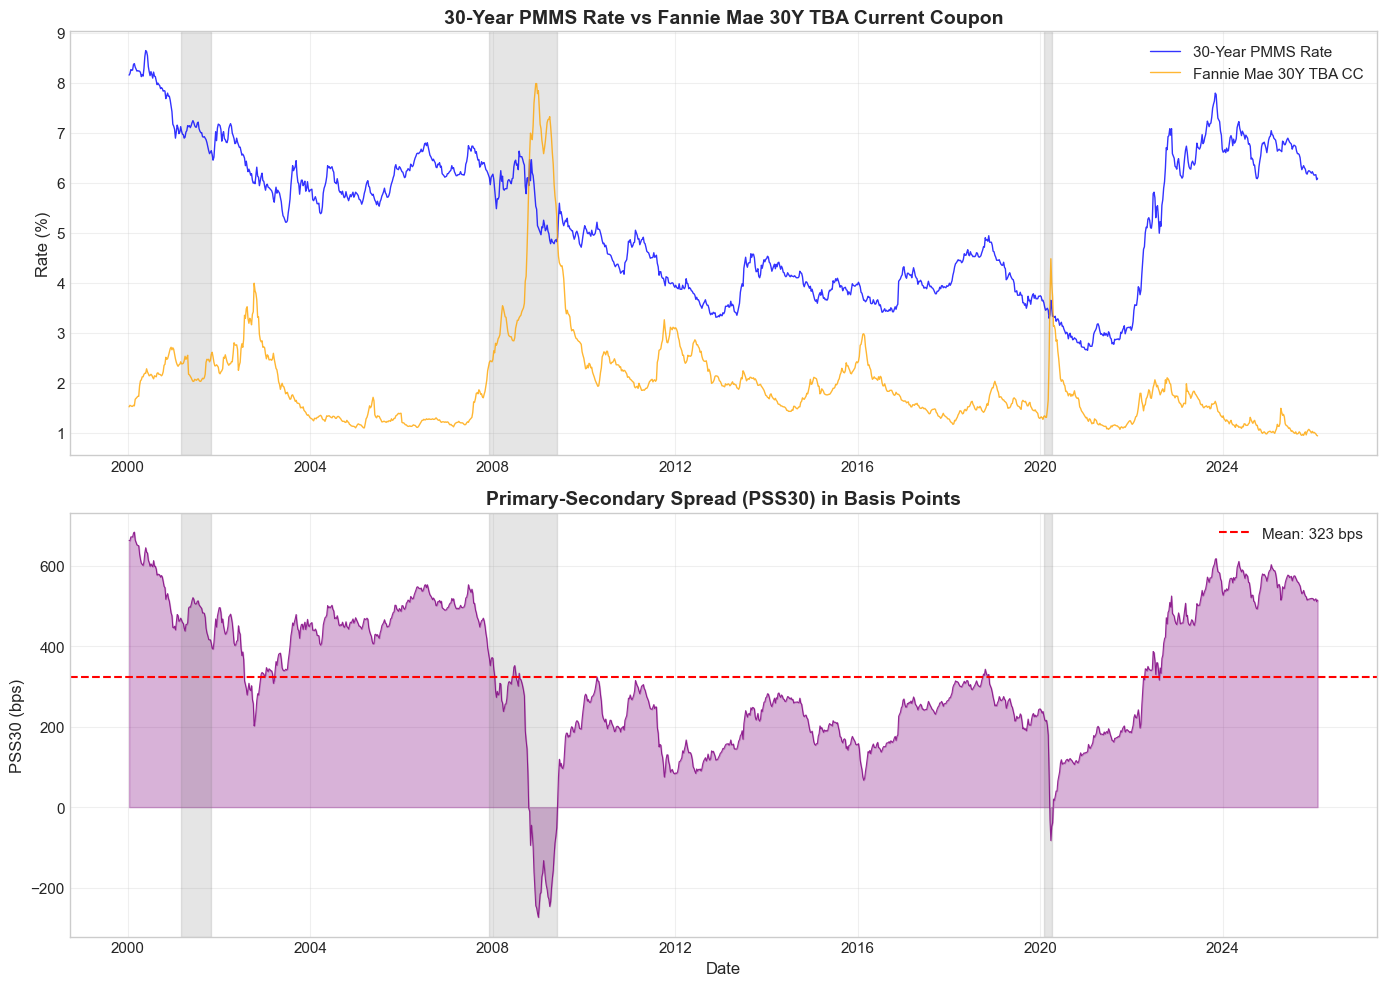

✓ Chart saved as: primary_secondary_spread_chart.png


In [16]:
# Problem 5-2: Chart - Visualize Primary-Secondary Spread
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: PMMS vs CC30 rates comparison
ax1 = axes[0]
ax1.plot(pss30_df.index, pss30_df['PMMS_30Y'], 
         'b-', linewidth=1, label='30-Year PMMS Rate', alpha=0.8)
ax1.plot(pss30_df.index, pss30_df['CC30'], 
         'orange', linewidth=1, label='Fannie Mae 30Y TBA CC', alpha=0.8)

ax1.set_title('30-Year PMMS Rate vs Fannie Mae 30Y TBA Current Coupon', fontsize=14, fontweight='bold')
ax1.set_ylabel('Rate (%)', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Add recession shading
for start, end in recessions:
    ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end), alpha=0.2, color='gray')

# Plot 2: Primary-Secondary Spread
ax2 = axes[1]
ax2.plot(pss30_df.index, pss30_df['PSS30'], 
         'purple', linewidth=0.8, alpha=0.8)
ax2.axhline(y=pss30_df['PSS30'].mean(), color='r', linestyle='--', 
            label=f'Mean: {pss30_df["PSS30"].mean():.0f} bps')
ax2.fill_between(pss30_df.index, pss30_df['PSS30'], alpha=0.3, color='purple')

ax2.set_title('Primary-Secondary Spread (PSS30) in Basis Points', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('PSS30 (bps)', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

for start, end in recessions:
    ax2.axvspan(pd.to_datetime(start), pd.to_datetime(end), alpha=0.2, color='gray')

plt.tight_layout()
plt.savefig('primary_secondary_spread_chart.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Chart saved as: primary_secondary_spread_chart.png")

---
## Problem 5-3: Regression Analysis of PSS30 on CC30

Run linear and non-linear (polynomial) regressions to analyze the relationship between the Primary-Secondary Spread and the Current Coupon rate.

In [17]:
# Problem 5-3: Regression Analysis

# Prepare data for regression
df_reg = pss30_df[['CC30', 'PSS30']].dropna()
X = df_reg[['CC30']].values
y = df_reg['PSS30'].values

print("="*70)
print("PROBLEM 5-3: REGRESSION ANALYSIS - PSS30 on CC30")
print("="*70)
print(f"\nSample size: {len(df_reg)} observations")
print(f"CC30 range: {X.min():.2f}% to {X.max():.2f}%")
print(f"PSS30 range: {y.min():.0f} to {y.max():.0f} bps")

PROBLEM 5-3: REGRESSION ANALYSIS - PSS30 on CC30

Sample size: 1328 observations
CC30 range: 0.94% to 7.98%
PSS30 range: -274 to 684 bps


In [18]:
# LINEAR REGRESSION
print("\n" + "="*60)
print("1. LINEAR REGRESSION")
print("="*60)

lr = LinearRegression()
lr.fit(X, y)
y_pred_linear = lr.predict(X)

r2_linear = r2_score(y, y_pred_linear)
rmse_linear = np.sqrt(mean_squared_error(y, y_pred_linear))

print(f"\nEquation: PSS30 = {lr.intercept_:.4f} + {lr.coef_[0]:.4f} × CC30")
print(f"R-squared: {r2_linear:.4f} ({r2_linear*100:.2f}% of variance explained)")
print(f"RMSE: {rmse_linear:.2f} basis points")
print(f"\nInterpretation:")
print(f"  - For every 1% increase in CC30, PSS30 changes by {lr.coef_[0]:.2f} bps")
print(f"  - When CC30 = 0, baseline PSS30 = {lr.intercept_:.2f} bps (extrapolated)")


1. LINEAR REGRESSION

Equation: PSS30 = 523.4054 + -101.0938 × CC30
R-squared: 0.3457 (34.57% of variance explained)
RMSE: 139.49 basis points

Interpretation:
  - For every 1% increase in CC30, PSS30 changes by -101.09 bps
  - When CC30 = 0, baseline PSS30 = 523.41 bps (extrapolated)


In [19]:
# POLYNOMIAL REGRESSION (DEGREE 2) - Quadratic
print("\n" + "="*60)
print("2. POLYNOMIAL REGRESSION (DEGREE 2) - QUADRATIC")
print("="*60)

poly2 = PolynomialFeatures(degree=2)
X_poly2 = poly2.fit_transform(X)
lr_poly2 = LinearRegression()
lr_poly2.fit(X_poly2, y)
y_pred_poly2 = lr_poly2.predict(X_poly2)

r2_poly2 = r2_score(y, y_pred_poly2)
rmse_poly2 = np.sqrt(mean_squared_error(y, y_pred_poly2))

print(f"\nEquation: PSS30 = {lr_poly2.intercept_:.4f} + {lr_poly2.coef_[1]:.4f}×CC30 + {lr_poly2.coef_[2]:.4f}×CC30²")
print(f"R-squared: {r2_poly2:.4f} ({r2_poly2*100:.2f}% of variance explained)")
print(f"RMSE: {rmse_poly2:.2f} basis points")
print(f"\nImprovement over linear: R² increased by {(r2_poly2-r2_linear)*100:.2f} percentage points")


2. POLYNOMIAL REGRESSION (DEGREE 2) - QUADRATIC

Equation: PSS30 = 553.5566 + -124.7341×CC30 + 3.3775×CC30²
R-squared: 0.3477 (34.77% of variance explained)
RMSE: 139.27 basis points

Improvement over linear: R² increased by 0.20 percentage points


In [20]:
# POLYNOMIAL REGRESSION (DEGREE 3) - Cubic
print("\n" + "="*60)
print("3. POLYNOMIAL REGRESSION (DEGREE 3) - CUBIC")
print("="*60)

poly3 = PolynomialFeatures(degree=3)
X_poly3 = poly3.fit_transform(X)
lr_poly3 = LinearRegression()
lr_poly3.fit(X_poly3, y)
y_pred_poly3 = lr_poly3.predict(X_poly3)

r2_poly3 = r2_score(y, y_pred_poly3)
rmse_poly3 = np.sqrt(mean_squared_error(y, y_pred_poly3))

print(f"\nR-squared: {r2_poly3:.4f} ({r2_poly3*100:.2f}% of variance explained)")
print(f"RMSE: {rmse_poly3:.2f} basis points")
print(f"\nImprovement over quadratic: R² increased by {(r2_poly3-r2_poly2)*100:.2f} percentage points")


3. POLYNOMIAL REGRESSION (DEGREE 3) - CUBIC

R-squared: 0.3553 (35.53% of variance explained)
RMSE: 138.46 basis points

Improvement over quadratic: R² increased by 0.76 percentage points


In [21]:
# REGRESSION COMPARISON SUMMARY
print("\n" + "="*60)
print("REGRESSION COMPARISON SUMMARY")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': ['Linear', 'Polynomial (Degree 2)', 'Polynomial (Degree 3)'],
    'R-squared': [r2_linear, r2_poly2, r2_poly3],
    'RMSE (bps)': [rmse_linear, rmse_poly2, rmse_poly3]
})
comparison_df['R-squared'] = comparison_df['R-squared'].apply(lambda x: f"{x:.4f}")
comparison_df['RMSE (bps)'] = comparison_df['RMSE (bps)'].apply(lambda x: f"{x:.2f}")
print("\n")
print(comparison_df.to_string(index=False))


REGRESSION COMPARISON SUMMARY


                Model R-squared RMSE (bps)
               Linear    0.3457     139.49
Polynomial (Degree 2)    0.3477     139.27
Polynomial (Degree 3)    0.3553     138.46


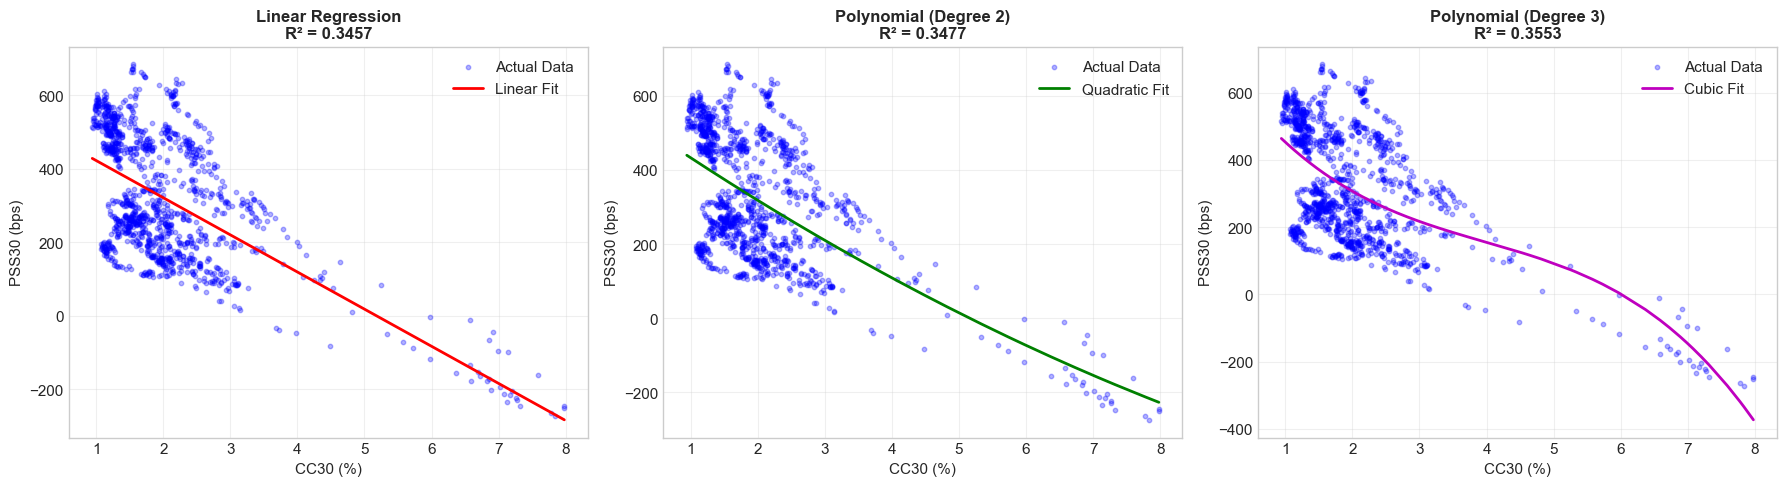

✓ Chart saved as: regression_analysis.png


In [22]:
# VISUALIZATION: Regression Results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Sort for plotting
sort_idx = np.argsort(X.flatten())

# Plot 1: Linear Regression
axes[0].scatter(X, y, alpha=0.3, s=10, c='blue', label='Actual Data')
axes[0].plot(X[sort_idx], y_pred_linear[sort_idx], 'r-', linewidth=2, label='Linear Fit')
axes[0].set_xlabel('CC30 (%)', fontsize=11)
axes[0].set_ylabel('PSS30 (bps)', fontsize=11)
axes[0].set_title(f'Linear Regression\nR² = {r2_linear:.4f}', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Polynomial Degree 2
axes[1].scatter(X, y, alpha=0.3, s=10, c='blue', label='Actual Data')
axes[1].plot(X[sort_idx], y_pred_poly2[sort_idx], 'g-', linewidth=2, label='Quadratic Fit')
axes[1].set_xlabel('CC30 (%)', fontsize=11)
axes[1].set_ylabel('PSS30 (bps)', fontsize=11)
axes[1].set_title(f'Polynomial (Degree 2)\nR² = {r2_poly2:.4f}', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Polynomial Degree 3
axes[2].scatter(X, y, alpha=0.3, s=10, c='blue', label='Actual Data')
axes[2].plot(X[sort_idx], y_pred_poly3[sort_idx], 'm-', linewidth=2, label='Cubic Fit')
axes[2].set_xlabel('CC30 (%)', fontsize=11)
axes[2].set_ylabel('PSS30 (bps)', fontsize=11)
axes[2].set_title(f'Polynomial (Degree 3)\nR² = {r2_poly3:.4f}', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('regression_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Chart saved as: regression_analysis.png")

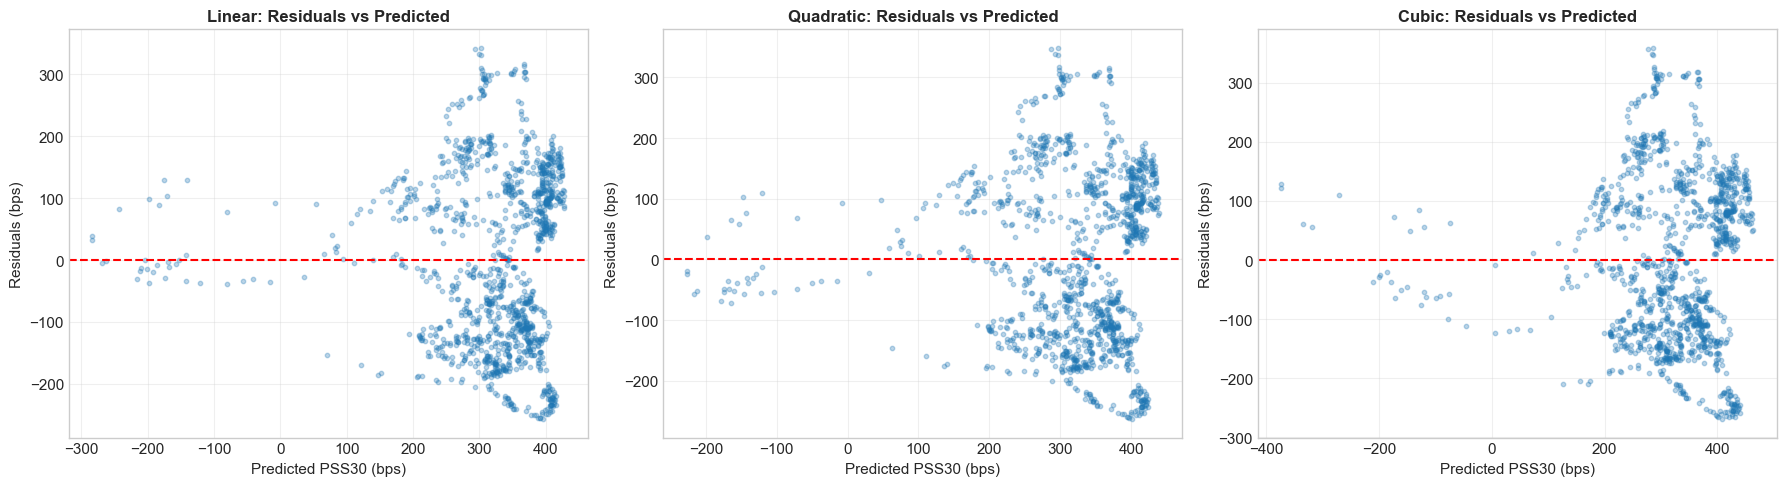

✓ Chart saved as: residual_analysis.png


In [23]:
# RESIDUAL ANALYSIS
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

residuals_linear = y - y_pred_linear
residuals_poly2 = y - y_pred_poly2
residuals_poly3 = y - y_pred_poly3

# Residual plot for Linear
axes[0].scatter(y_pred_linear, residuals_linear, alpha=0.3, s=10)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted PSS30 (bps)')
axes[0].set_ylabel('Residuals (bps)')
axes[0].set_title('Linear: Residuals vs Predicted', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Residual plot for Poly2
axes[1].scatter(y_pred_poly2, residuals_poly2, alpha=0.3, s=10)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted PSS30 (bps)')
axes[1].set_ylabel('Residuals (bps)')
axes[1].set_title('Quadratic: Residuals vs Predicted', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Residual plot for Poly3
axes[2].scatter(y_pred_poly3, residuals_poly3, alpha=0.3, s=10)
axes[2].axhline(y=0, color='r', linestyle='--')
axes[2].set_xlabel('Predicted PSS30 (bps)')
axes[2].set_ylabel('Residuals (bps)')
axes[2].set_title('Cubic: Residuals vs Predicted', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('residual_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Chart saved as: residual_analysis.png")

---
## Problem 5-3: Conclusions, Limitations, and Recommendations

### Regression Results Summary

Based on the regression analysis of PSS30 (Primary-Secondary Spread) on CC30 (Current Coupon Rate):

**Model Performance:**
- Linear and polynomial models capture some relationship between CC30 and PSS30
- Higher-degree polynomials may provide better fit but risk overfitting

### Limitations of the Regression Analysis

1. **Omitted Variable Bias**: The spread is affected by many factors beyond just CC30:
   - Origination capacity and pipeline
   - Mortgage application volume
   - Interest rate volatility (MOVE index)
   - Prepayment expectations
   - Credit conditions

2. **Non-Stationarity**: The relationship between PSS30 and CC30 changes over time due to:
   - Structural market changes
   - Regulatory changes
   - Technology improvements in mortgage processing

3. **Structural Breaks**: Crisis periods (2008, 2020) create outliers and regime changes

4. **Endogeneity**: CC30 and PSS30 may be simultaneously determined by common factors

5. **Heteroscedasticity**: Variance of residuals may not be constant across rate levels

### Recommendations to Improve Predictions

1. **Add More Explanatory Variables**:
   - MBA Mortgage Application Index
   - Swaption implied volatility
   - Yield curve slope (10Y-2Y)
   - Prepayment speeds (CPR)
   - Lender capacity measures

2. **Time-Series Methods**:
   - ARIMA models for spread dynamics
   - GARCH models for volatility clustering
   - VAR models for feedback effects

3. **Regime-Switching Models**: Capture different market states (normal vs. crisis)

4. **Machine Learning**: Random Forest, XGBoost for non-linear relationships

5. **Rolling Window Analysis**: Capture time-varying coefficients

6. **Include Lagged Variables**: Account for delayed market reactions